<a href="https://colab.research.google.com/github/danielsabino/imd0188_am_2022_1/blob/main/05_AM_Nao_supervisionado/exemplos/animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamento

Este notebook traz um exemplo básico de como executar um algoritmo de agrupamento.

## Importando módulos

Vamos utilizar poucos módulos para esta primeira parte. O `pandas` para tratar os dados como dataframes, o `matplotlib` para conseguir plotar alguns gráficos e o `gdown` para baixar a base de dados.

In [ ]:
# pandas para usar dataframes
import pandas as pd
# matplotlib para plotar gráficos
import matplotlib.pyplot as plt
# gdown para baixar os dados
import gdown

Alguns outros módulos vão ser importados depois a medida que forem necessários.

## Obtendo os dados

Para demonstrar o funcionamento de um algoritmo de agrupamento, vamos utilizar uma base de dados de animais. Essa base contém características específicas de animais e uma categoria para cada um deles.

In [ ]:
# url da base de dados
url = 'https://drive.google.com/file/d/1edRuz54pedMX4C8fzDMun9nwxgvzKmm8/view?usp=sharing'
# nome do arquivo que vai ser gerado
output = 'animals.csv'
# baixa os dados
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1edRuz54pedMX4C8fzDMun9nwxgvzKmm8
To: /content/animals.csv
100%|██████████| 12.0k/12.0k [00:00<00:00, 7.11MB/s]


'animals.csv'

Depois de carregar os dados, vamos verificar quantos objetos, atributos e quais são os seus tipos.

In [ ]:
dataset = pd.read_csv('animals.csv', sep=';')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hair      101 non-null    bool   
 1   feathers  101 non-null    bool   
 2   eggs      101 non-null    bool   
 3   milk      101 non-null    bool   
 4   airborne  101 non-null    bool   
 5   aquatic   101 non-null    bool   
 6   predator  101 non-null    bool   
 7   toothed   101 non-null    bool   
 8   backbone  101 non-null    bool   
 9   breathes  101 non-null    bool   
 10  venomous  101 non-null    bool   
 11  fins      101 non-null    bool   
 12  legs      101 non-null    float64
 13  tail      101 non-null    bool   
 14  domestic  101 non-null    bool   
 15  catsize   101 non-null    bool   
dtypes: bool(15), float64(1)
memory usage: 2.4 KB


Podemos ver que temos 16 atributos referentes a características dos animiais. A maioria dos atributos é do tipo booleano, indicando a presença ou não daquela característica no animal. Existe um único atributo numérico que indica o número de pernas do animal.

Vamos olhar alguns exemplos desses dados.

In [ ]:
dataset.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,True,False,False,True,False,False,True,True,True,True,False,False,4.0,False,False,True
1,True,False,False,True,False,False,False,True,True,True,False,False,4.0,True,False,True
2,False,False,True,False,False,True,True,True,True,False,False,True,0.0,True,False,False
3,True,False,False,True,False,False,True,True,True,True,False,False,4.0,False,False,True
4,True,False,False,True,False,False,True,True,True,True,False,False,4.0,True,False,True


## Agrupamento inicial

Podemos iniciar a análise fazendo um agrupamento inicial por meio de algoritmo hierárquico. Essa etapa pode fornecer alguns _insights_ sobre a distribuição dos objetos.

o `scipy` possui uma implementação do algoritmo hierárquico, mais especificamente da função de _linkage_ do algoritmo para conseguir agrupar os dados de acordo com o tipo de ligação feita para unir os grupos. O mesmo pacote fornece uma função para plotar o dendrograma da estrutura hierárquica gerada.

Para fins de exemplo, vamos iniciar com uma similaridade baseada no cosseno e usando a ligação média entre os grupos.

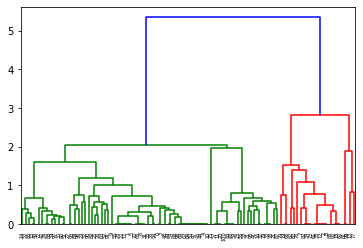

In [ ]:
# importa os métodos linkage e dendrogram para construir a estrutura hierárquica
from scipy.cluster.hierarchy import linkage,dendrogram
# importa do sklearn a similaridade do cosseno
from sklearn.metrics.pairwise import cosine_similarity

# obtendo medida de distância baseada no cosseno
similarity_distance = 1 - cosine_similarity(dataset)

# computa a sequência de grupos unidos usando a ligação média
mergings = linkage(similarity_distance, method='average')

# configura o dendrograma
dendrogram_ = dendrogram(mergings,
               leaf_rotation=90
)

Primeiro, é importante notar que usamos `1 - cosine_similarity` para computar as distâncias entre os objetos. Isso é importante, já que os dendrogramas estão programados para funcionar com medidas de distância e a função `cosine_similarity` computa, como o próprio nome diz, a similaridade. Então, para realizar uma transformação simplista dessa medida em distância, computamos seu complemento em relação ao que seria ao maior grau de similaridade (1).

As cores são atribuídas automaticamente pela função que gera o dendrograma e não representam automaticamente grupos. O importante neste passo é verificar a forma como os dados são distribuídos e as distâncias entre os grupos formados.

A distância entre os grupos é medida pelo comprimento do ramo dentro do dendrograma. Quanto maior esse ramo, mais distantes estão os grupos. Pela figura anterior, podemos perceber que existem alguns níveis de grupos:

1. dois grandes grupos, representados pelas cores verde e vermelho;
2. cinco grupos mais específicos (três subgrupos no ramo verde e dois no ramo vermelho)

Olhe novamente e faça sua própria interpretação.

## Definindo número de grupos

Podemos simplesmente encerrar a análise e utilizar os grupos com base no agrupamento hierárquico anterior. Mas, podemos também utilizar outros recursos que ajudam na etapa de interpretação dos dados.

Vamos inicialmente, tentar descobrir qual o número de grupos mais adequado para dividir os dados.

Para isso, vamos fazer uso de um índice relativo para medir o quão compacto os grupos estão (o erro quadrático médio, nesse caso). De posse desse índice, podemos dividir os dados em variados números de grupos e verificar o comportamento do índice para tentar obter um valor adequado.

Vale salientar que esse índice (assim como outros) tende a ser, em geral, monotônico. Isso é natural, já que quanto mais grupos geramos, mais compactos são. Então, devemos ficar atentos a pontos de mudança de comportamento ao invés de olhar simplesmente o mínimo.

Como queremos fazer uma divisão com quantidades de grupos diferentes, podemos automatizar esse processo utilizando o algoritmo k-means.

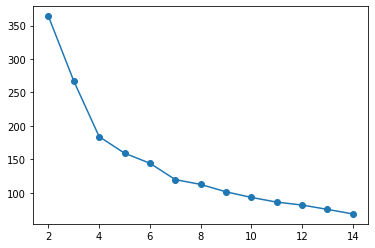

In [ ]:
# importando algoritmo k-means 
from sklearn.cluster import KMeans
%matplotlib inline

# quantidade de grupos que vamos realizar os testes
ks = range(2, 15)
# armazena o valor do índice para cada partição gerada
inertias = []
for k in ks:
  # executa o k-means para aquela quantidade de grupos
  km = KMeans(n_clusters=k, random_state=8)
  # aplica a configuração do agrupamento gerado aos dados para obter o índice
  km.fit(dataset)
  # calcula o erro quadrático médio
  inertias.append(km.inertia_)
# plota o gráfico
plt.plot(ks, inertias, marker='o')

Conforme esperado, o índice descresce continuamente. No entanto, existem alguns locais que chamam a atenção: 

1. uma redução da magnitude da queda entre após 4 grupos.
2. uma segunda queda mais significativa com 7 grupos.

Apesar de serem somente indícios, é um bom início para analisar os dados.

Uma outra análise a ser feita é a distribuição da quantidade de objetos em cada grupo a medida que vamos aumentando a quantidade desses grupos. 

Essa análise fornece uma visão de quão homogêneos alguns grupos são com relação a outros. Por exemplo, se um grupo tende a não ser dividido quando aumentamos o número total de grupos, pode significar que existe uma certa homogeneidade dos objetos dentro daquele grupo.

Vamos fazer um experimento semalhentes ao anterior, mas olhando para a quantidade de objetos em cada grupo a medida que aumentamos a quantidade total de grupos na partição.

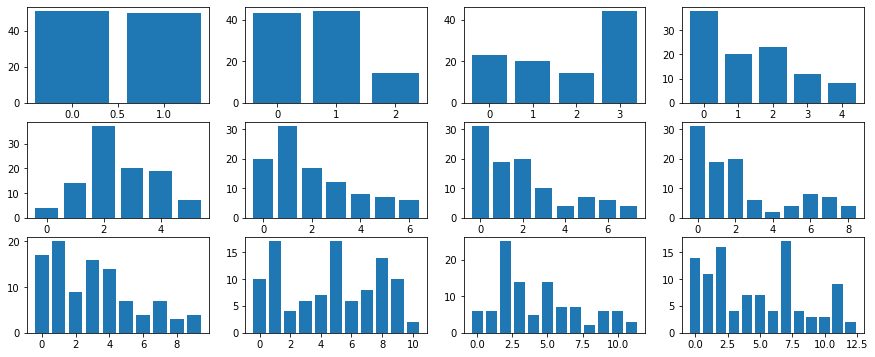

In [ ]:
# configuração do gráfico que vai ser gerado
fig, axs = plt.subplots(3,4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()

# dataframe para armazenar os dados
df = pd.DataFrame()

# intervalo com a quantidade de grupos que vamos dividir os dados
ks = range(2, 14)
for k in ks:
  # executa o kmeans para cada quantidade de grupos
  km = KMeans(n_clusters=k, random_state=8)
  # relaciona o resultado gerado com os dados da base
  km.fit(dataset)
  # resgata os rótulos (grupos) para cada objeto da base
  labels = km.labels_.tolist()
  # cria um dataframe para facilitar a contagem dos objetos em cada grupo 
  df['labels'] = labels
  # segundo dataframe somente para realizar a contagem
  df2 = df['labels'].value_counts()
  # plot os graficos 
  axs[k-2].bar(df2.index,df2.values)

A partir dos gráficos, dá para notar que quando dividimos os dados, notamos os seguintes comportamentos:

- 2 grupos: os grupos ficam balanceados com cerca de metade dos objetos em cada;
- 3 grupos: o terceiro grupo criado possui elementos dos outros dois grupos;
- 4 grupos: um quarto grupo é criado, mas um dos grupos permanece com basicamente a mesma quantidade de objetos. Isso pode indicar que existeum uniformidade maior nesse grupo maior, enquanto que os demais ainda estão muito heterogêneos;
- 5 grupos: o grupo maior ainda permanece e outros dois grupos parecem se manter com cerca de 20 objetos.

Para as demais quantidades de grupos, o comportamento é semelhantes: alguns grupos vão se estabilizando com uma quantidade de objetos enquanto que outros vão se dividindo. Ao final, percebe-se a existência de um grupo que possui mais elementos que todos os demais, alguns outros grupos que possuem entre 15 e 20 objetos e alguns grupo menores.

Claro que ao dividirmos demais a base, cada grupo tende a se tornar menor, o que passa a prejudicar a análise, já que os grupos mais homogêneos também passam a se dividir.

Como, então, fazer essa análise? Uma das formas é analisar os objetos representantes de cada grupo para extrair as informações pertinentes.

## Análise de centroides e interpretação do agrupamento

Para entender o que cada grupo desse significa, devemos analisar os dados e, com conhecimento específico, extrair informações úteis.

Como estamo com uma base de dados simples que contém descrições de animais, conseguimos com conhecimento de mundo fazer algumas inferências.

Vamos novamente realizar o agrupamento dos dados usando o algoritmo k-means com diferentes valores de $k$. Para cada execução, vamos analisar os centrois dos grupos e verificar se existe algo útil a ser revelado.

In [ ]:
# executando k-means com dois grupos
km = KMeans(n_clusters=2, random_state=8)
km.fit(dataset)
# obtendo os dois centroides
centers = km.cluster_centers_
# imprimindo os valores dos centroides
print(centers)

[[ 6.86274510e-01 -8.32667268e-17  3.92156863e-01  6.07843137e-01
   1.17647059e-01  2.15686275e-01  5.49019608e-01  6.86274510e-01
   7.25490196e-01  9.01960784e-01  7.84313725e-02 -2.77555756e-17
   4.56862745e+00  6.27450980e-01  1.56862745e-01  5.29411765e-01]
 [ 1.60000000e-01  4.00000000e-01  7.80000000e-01  2.00000000e-01
   3.60000000e-01  5.00000000e-01  5.60000000e-01  5.20000000e-01
   9.20000000e-01  6.80000000e-01  8.00000000e-02  3.40000000e-01
   1.08000000e+00  8.60000000e-01  1.00000000e-01  3.40000000e-01]]


Em um primeiro momento, os dados mostrados não informam muita coisa. Mas, vamos lembrar que os centroides são calculados a partir do valor médio de todos os pontos de um grupo. Então, é muito provável que o centroide seja um ponto no espaço de características, mas não um objeto em si. Por isso, os dados mostrados podem não fazer muito sentido (a maioria das características são binários e temos valores bastante diferentes de 0s e 1s).

Para fazer mais sentido, vamos realizar uma aproximação dos valores para algo mais próximo ao que se é esperado de um objeto desse conjunto de dados. Ou seja, um simples arredondamento desses valores deve resolver o problema de compreensão.

In [ ]:
# arredondando os valores das features e representando como inteiro para facilitar a visualização
centroids = pd.DataFrame(centers.round().astype(int))
# imprimindo os títulos das colunas
centroids.columns = dataset.keys().values
centroids.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,1,1,1,1,0,0,5,1,0,1
1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,0,0


Com a divisão em dois grupos, a maioria dos atributos é igual para os dos centroides, com exceção de `hair`, `eggs`, `milk`, `legs` e `catsize`.

Com essa divisão, podemos perceber que temos em um grupo animais que:
1. possuem pelo
2. não põem ovos
3. produzem leite
4. tem mais de uma perna
5. são de pequeno porte

No outro grupo, temos animais que: 
1. não possuem pelo
2. põem ovos
3. não produzem leite
4. possuem uma perna
5. não são de pequeno porte

Algumas dessas coisas não fazem sentido, como ter somente uma perna (ou ter cinco pernas). Mas, já coloca um bom diferencial entre os animais. Claramente, os primeiros estão mais ligados a mamíferos. A segunda categoria ainda parece mais indefinida. 

Vamos fazer uma nova divisão com três grupos.

In [ ]:
km = KMeans(n_clusters=3, random_state=8)
km.fit(dataset)
centers = km.cluster_centers_
centroids = pd.DataFrame(centers.round().astype(int))
centroids.columns = dataset.keys().values
centroids.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,0,0,1,0,0,1,1,0,1,1,0,0,1,1,0,0
1,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0


Com três grupos, o grupo dos mamíferos parece mais evidente agora já que manteve as cararísticas principais da divisão anterior, mas o número de pernas veio para quatro, o que pode indicar um conjunto de quadrúpedes.

Os outros dois grupos são de animais que não mamíferos, mas com características já bem diferentes. O primeiro grupo (grupo 0) é de animais aquáticos e predadores. Além disso, possuem uma coluna vertebral, cauda e um número de pernas bem pequeno (média de uma perna - podem então, ser 0 ou 2 pernas). Essas características são mais próximas répteis.

Por outro lado, o grupo 2 traz duas características interessantes, não possuírem coluna vertebral e terem uma quantidade média de pernas alta (média de seis pernas). Essas características parecem próximas a de insetos.

Nesse ponto, parece haver uma boa divisão das classes dos animais. Mas, podemos continuar dividindo para ver se existem outras categorias ou subdivisões de uma mesma categoria.

In [ ]:
km = KMeans(n_clusters=4, random_state=8)
km.fit(dataset)
centers = km.cluster_centers_
centroids = pd.DataFrame(centers.round().astype(int))
centroids.columns = dataset.keys().values
centroids.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
1,0,1,1,0,1,0,0,0,1,1,0,0,2,1,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


Na divisão em quatro grupos, o grupos dos mamíferos se manteve presente, mas os outros grupos sofreram divisões. Agora, é possível ver claramente uma nova classe, já que o atributo `feathers` juntamente como o número de pernas (`legs`) e a indicação que voam (`airborne`) estão presentes somente em um grupo. Isso deve indicar que os animais ali colocados são _aves_.

No grupo 0, podemos ver um atributo que o diferencia dos demais: possui barbatanas (`fins`). Esse dado, juntamente com a ideia de que o atributo `breathe` e o número de pernas (zero), claramente coloca esse grupo como o contendo _peixes_.

Até o momento, identificamos possíveis classes de animais:

1. mamíferos
2. insetos
3. aves
4. répteis
5. peixes

Apesar de termos vistos características dessas cinco classes, duas delas não apareceram ao mesmo tempo: répteis e peixes. Então, vamos fazer uma divisão em cinco grupos para ver se isso acontece.

In [ ]:
km = KMeans(n_clusters=5, random_state=8)
km.fit(dataset)
centers = km.cluster_centers_
centroids = pd.DataFrame(centers.round().astype(int))
centroids.columns = dataset.keys().values
centroids.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
1,0,1,1,0,1,0,0,0,1,1,0,0,2,1,0,0
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0
4,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0


Com essa divisão, podemos perceber que:
- grupo 0: mamíferos
- grupo 1: aves
- grupo 2: peixes
- grupo 3: insetos
- grupo 4: répteis

O último grupo está sendo atribuído a classe répteis porque todas as características são de animais dessa categoria, apesar de não saber exatamente se todos dentro do grupo compartilham essa classe.

Vamos verificar os objetos dentro desse grupo.

In [ ]:
dataset[km.labels_ == 4]

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
14,False,False,True,False,False,True,True,False,False,False,False,False,4.0,False,False,False
25,False,False,True,False,False,True,True,True,True,True,False,False,4.0,False,False,False
26,False,False,True,False,False,True,True,True,True,True,True,False,4.0,False,False,False
52,False,False,True,False,False,True,True,True,True,True,False,False,4.0,True,False,False
85,False,False,True,False,False,True,True,False,False,False,False,False,5.0,False,False,False
89,False,False,True,False,False,True,False,True,True,True,False,False,4.0,False,False,False
90,False,False,True,False,False,False,False,False,True,True,False,False,4.0,True,False,True
91,False,False,True,False,False,False,True,True,True,True,False,False,4.0,True,False,False


Pelos valores dos atributos, com exceção de `backbone`, não existe indicativo que os animais sejam necessariamente diferente de répteis. Um dos objetos possui cinco pernas, mas pode ser um ruído na base de dados.

Novas divisões podem ser feitas com mais grupos, no entanto, o risco de dividir um grupo "estável" para conseguir buscar outras categorias aumenta a cada valor maior de $k$.

A decisão de continuar dividindo os dados ou não depende da necessidade da aplicação. Se o objetivo, por exemplo, fosse garantir a perpetuação das espécies, faria sentido tentar dividir ao máximo para garantir que os predadores não fiquem em um mesmo grupo que as presas. Se a ideia fosse construir um portfolio de fotos, essa necesside não deveria ser tão forte. Ou ainda, se fosse para contratar profissionais para cuidar/gerenciar os animais, mas só existisse recurso para três pessoas, o número de grupos teria que ser menor. No fim, a necessidade que motivou o agrupamento deve prevalecer.

Uma classe não explorada foi a dos anfíbios. Provavelmente, se existirem anfíbios na base de dados, devem estar em menor quantidade e inseridos dentro dos grupos dos peixes ou répteis. 

Para fins de exemplo, vamos executar o agrupamento com mais grupos somente para ver como seriam grupos. 

In [ ]:
from IPython.display import display

ks = range(6, 10)
for k in ks:    
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(dataset)
    centers = km.cluster_centers_
    centroids = pd.DataFrame(centers.round().astype(int))
    centroids.columns = dataset.keys().values
    display(centroids)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1
1,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
2,0,1,1,0,1,0,0,0,1,1,0,0,2,1,0,0
3,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1
5,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,0,1,1,0,1,0,0,0,1,1,0,0,2,1,0,0
1,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0
6,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,1,1,0,1,0,0,0,1,1,0,0,2,1,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0
4,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0
5,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,0,1,1,0,1,0,0,0,1,1,0,0,2,1,0,0
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,0,0,1,0,0,1,1,0,0,0,0,0,7,0,0,0
4,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0
7,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1
8,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


A análise desses grupos fica como exercício. Note que não descobrimos quem são todos os animais. O objetivo do agrupamento não é esse. A ideia principal é encontrar formas de organizar os dados (ou elementos da vida real) em grupos (posteriormente categorias se analisadas) para descobrir informações presentes nesses dados.

Com a ajuda de um especialista, esses dados podem ser rotulados e utilizados, inclusive, por um algoritmo supervisionado para treinar um classificador.

Ficou curioso para saber quais são os animais na base de dados? Clique [aqui](https://drive.google.com/file/d/1eO0hzdo0qNlw9eG8Twrq5L2fEKEp7KBq/view?usp=sharing) para obter a base com os rótulos.

